In [15]:
import os
import glob
import hashlib
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import skew, kurtosis

In [16]:
# Set up paths and categories
data_dir = '../data/raw'
categories = ['Alarm_Clock', 'Car_Horn', 'Glass_Breaking', 'Gunshot', 'Siren', 'Background']

# Initialize lists to collect data
file_data = []

# Thresholds for anomalies
SILENCE_RMS_THRESHOLD = 0.015  # Arbitrary threshold for detecting silence (low RMS)
CLIPPING_THRESHOLD = 0.98 # Close to 1 for clipping detection

In [17]:
# Function to compute MD5 hash of file content for duplicate detection
def compute_file_hash(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Function to extract audio metadata and features
def extract_audio_info(file_path, category):
    try:
        y, sr = librosa.load(file_path, sr=None, mono=False)  # Load without resampling, keep stereo if present
        if y.ndim > 1:  # Stereo to mono for analysis 
            y_mono = librosa.to_mono(y)
        else:
            y_mono = y
        duration = librosa.get_duration(y=y, sr=sr)
        channels = y.ndim if y.ndim > 1 else 1
        bit_depth = y.dtype.itemsize * 8 if y.dtype.kind == 'i' else 'float'  # Approximate
        rms = np.mean(librosa.feature.rms(y=y_mono))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y_mono))
        max_amp = np.max(np.abs(y_mono))
        is_clipped = max_amp >= CLIPPING_THRESHOLD
        is_silent = rms < SILENCE_RMS_THRESHOLD
        # Simple SNR estimate
        noise_estimate = np.min(librosa.feature.rms(y=y_mono)) + 1e-6  # Avoid div0
        snr = 20 * np.log10(rms / noise_estimate) if rms > 0 else 0
        
        # Estimated frames for YAMNet (0.96s windows, non-overlapping for estimate)
        frame_length_sec = 0.96
        num_frames = int(np.ceil(duration / frame_length_sec)) if duration > 0 else 0
        
        file_hash = compute_file_hash(file_path)
        
        return {
            'file': os.path.basename(file_path),
            'category': category,
            'duration_sec': duration,
            'sample_rate_hz': sr,
            'channels': channels,
            'bit_depth': bit_depth,
            'rms_mean': rms,
            'zcr_mean': zcr,
            'max_amp': max_amp,
            'is_clipped': is_clipped,
            'is_silent': is_silent,
            'snr_db': snr,
            'num_estimated_frames': num_frames,
            'file_hash': file_hash,
            'load_success': True
        }
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return {
            'file': os.path.basename(file_path),
            'category': category,
            'duration_sec': None,
            'sample_rate_hz': None,
            'channels': None,
            'bit_depth': None,
            'rms_mean': None,
            'zcr_mean': None,
            'max_amp': None,
            'is_clipped': False,
            'is_silent': False,
            'snr_db': None,
            'num_estimated_frames': 0,
            'file_hash': None,
            'load_success': False
        }


In [18]:
# Traverse directories and collect data
for category in categories:
    category_dir = os.path.join(data_dir, category)
    wav_files = glob.glob(os.path.join(category_dir, '*.wav'))
    print(f"Found {len(wav_files)} files in {category}")
    
    for file_path in tqdm(wav_files, desc=f"Processing {category}"):
        info = extract_audio_info(file_path, category)
        file_data.append(info)

# Convert to DataFrame
df = pd.DataFrame(file_data)

# Save raw data to CSV
df.to_csv('audio_data_exploration.csv', index=False)
print("Saved raw data to 'audio_data_exploration.csv'")

Found 124 files in Alarm_Clock


Processing Alarm_Clock: 100%|██████████| 124/124 [00:00<00:00, 437.45it/s]


Found 198 files in Car_Horn


Processing Car_Horn: 100%|██████████| 198/198 [00:00<00:00, 440.38it/s]


Found 123 files in Glass_Breaking


Processing Glass_Breaking: 100%|██████████| 123/123 [00:00<00:00, 246.25it/s]


Found 198 files in Gunshot


Processing Gunshot: 100%|██████████| 198/198 [00:00<00:00, 342.75it/s]


Found 200 files in Siren


Processing Siren: 100%|██████████| 200/200 [00:00<00:00, 409.38it/s]


Found 200 files in Background


Processing Background: 100%|██████████| 200/200 [00:00<00:00, 389.02it/s]

Saved raw data to 'audio_data_exploration.csv'



Class Distribution:
category
Siren             200
Background        200
Car_Horn          198
Gunshot           198
Alarm_Clock       124
Glass_Breaking    123
Name: count, dtype: int64
Total Files: 1043
Imbalance Ratio (max/min): 1.63


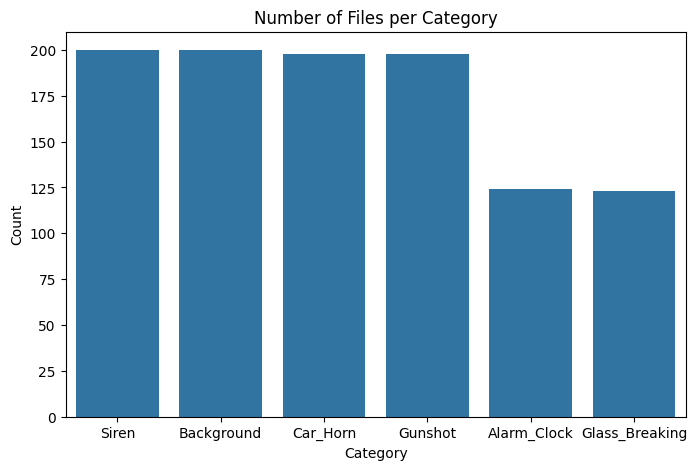

In [19]:
# Class Distribution, Balance, Total Samples, Imbalance Ratio
class_counts = df['category'].value_counts()
total_files = len(df)
print("\nClass Distribution:")
print(class_counts)
print(f"Total Files: {total_files}")
imbalance_ratio = class_counts.max() / class_counts.min() if class_counts.min() > 0 else float('inf')
print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("Warning: Dataset is imbalanced; consider weighting or augmentation.")

plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Number of Files per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Augmentation Needs
if total_files < 1000:
    print("Small dataset detected; suggest 5-10x augmentation multiplier for training.")

In [20]:
# File Integrity and Sanity Checks (Corrupt, Duplicates, Naming)
failed_loads = df[~df['load_success']]
print(f"\nFailed Loads (Corrupt Files): {len(failed_loads)}")
if not failed_loads.empty:
    print(failed_loads[['file', 'category']])

# Duplicates by hash
duplicates = df[df.duplicated(subset=['file_hash'], keep=False) & df['file_hash'].notna()]
print(f"Duplicate Files by Content: {len(duplicates) // 2 if len(duplicates) > 0 else 0}")
if not duplicates.empty:
    print(duplicates[['file', 'category', 'file_hash']])

# Naming Conventions
all_wav = all(f.endswith('.wav') for f in df['file'])
unique_names = df['file'].nunique() == len(df)
print(f"All files end with .wav: {all_wav}")
print(f"All file names unique: {unique_names}")


Failed Loads (Corrupt Files): 0
Duplicate Files by Content: 38
                       file        category                         file_hash
323    Glass_Breaking_1.wav  Glass_Breaking  7e0cd194243fef08c8113b19d9862cdd
324   Glass_Breaking_10.wav  Glass_Breaking  4cba02c37495a26bf0bf9d40b7381aac
325  Glass_Breaking_100.wav  Glass_Breaking  7dd52d2deb683036bd6f20c6c863d5aa
326  Glass_Breaking_101.wav  Glass_Breaking  97d137d787a5eb5e80b5b889bc720fe5
327  Glass_Breaking_102.wav  Glass_Breaking  a32910341015541cbf8d73b4d1592119
..                      ...             ...                               ...
437   Glass_Breaking_91.wav  Glass_Breaking  41566b6d948a33299cd2c53ee2841461
439   Glass_Breaking_93.wav  Glass_Breaking  7e4ac3ed3026fb2c522942814c301424
440   Glass_Breaking_94.wav  Glass_Breaking  97d137d787a5eb5e80b5b889bc720fe5
441   Glass_Breaking_95.wav  Glass_Breaking  d322e18bbdf3d0c1306acee2631f5f47
442   Glass_Breaking_96.wav  Glass_Breaking  5b1b61ed3a88cb778dedc00a1e8a6720



Duration Stats per Category (seconds):
                     min   max      mean  median       std       var
category                                                            
Alarm_Clock     2.000000   2.0  2.000000     2.0  0.000000  0.000000
Background      2.000000   2.0  2.000000     2.0  0.000000  0.000000
Car_Horn        1.532500   2.0  1.997639     2.0  0.033224  0.001104
Glass_Breaking  0.702562  10.0  4.393270     5.0  2.356685  5.553964
Gunshot         2.000000   2.0  2.000000     2.0  0.000000  0.000000
Siren           2.000000   2.0  2.000000     2.0  0.000000  0.000000

Overall Duration Stats (seconds):
min        0.702562
max       10.000000
mean       2.281788
median     2.000000
std        1.116744
var        1.247117
Name: duration_sec, dtype: float64


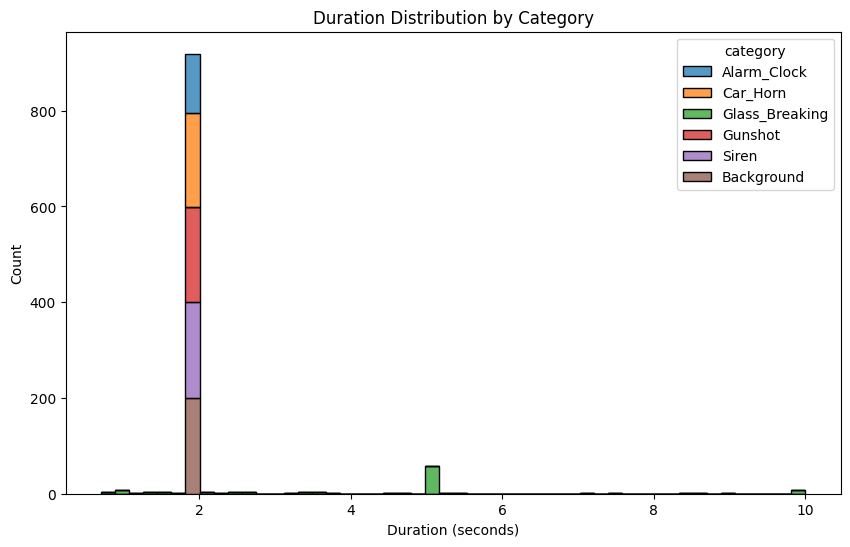

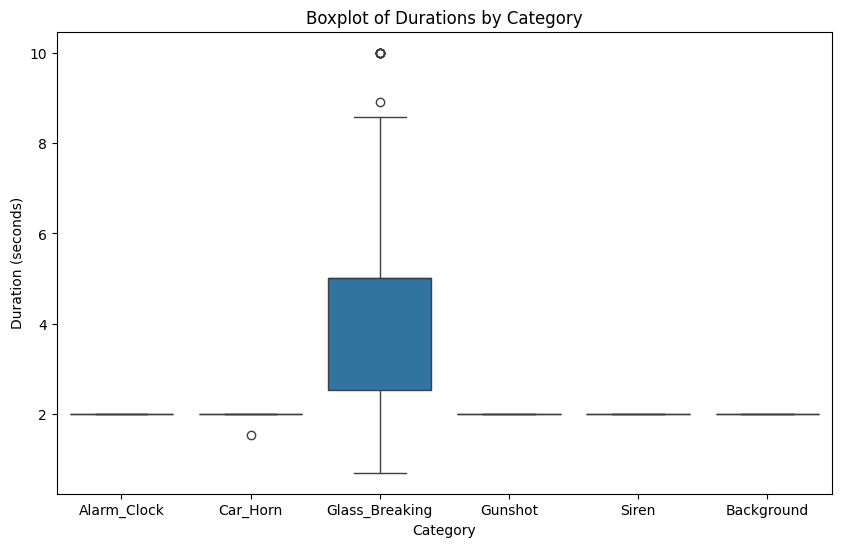

Files shorter than 0.96s (need padding): 7
Files longer than 10s (may need trimming): 0


In [21]:
# Duration Statistics and Distribution
duration_stats = df.groupby('category')['duration_sec'].agg(['min', 'max', 'mean', 'median', 'std', 'var'])
overall_duration_stats = df['duration_sec'].agg(['min', 'max', 'mean', 'median', 'std', 'var'])
print("\nDuration Stats per Category (seconds):")
print(duration_stats)
print("\nOverall Duration Stats (seconds):")
print(overall_duration_stats)

# Histograms and Boxplots
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='duration_sec', hue='category', multiple='stack', bins=50)
plt.title('Duration Distribution by Category')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='duration_sec')
plt.title('Boxplot of Durations by Category')
plt.xlabel('Category')
plt.ylabel('Duration (seconds)')
plt.show()

# Very short/long files
short_files = df[df['duration_sec'] < 0.96]
long_files = df[df['duration_sec'] > 10]
print(f"Files shorter than 0.96s (need padding): {len(short_files)}")
print(f"Files longer than 10s (may need trimming): {len(long_files)}")


In [22]:
# Sample Rate Consistency
sr_counts = df['sample_rate_hz'].value_counts()
print("\nSample Rate Distribution:")
print(sr_counts)
unique_srs = sr_counts.index.tolist()
if len(unique_srs) > 1:
    print("Warning: Multiple sample rates detected; resampling to 16kHz required.")
elif unique_srs[0] != 16000:
    print(f"Warning: Uniform sample rate {unique_srs[0]} Hz; resample to 16kHz for YAMNet.")



Sample Rate Distribution:
sample_rate_hz
16000    1043
Name: count, dtype: int64


In [23]:
# Number of Channels
channels_counts = df['channels'].value_counts()
print("\nChannels Distribution:")
print(channels_counts)
if 2 in channels_counts.index:
    print("Note: Stereo files detected; convert to mono for consistency.")


Channels Distribution:
channels
1    1043
Name: count, dtype: int64


In [24]:
# Bit Depth
bit_depth_counts = df['bit_depth'].value_counts()
print("\nBit Depth Distribution:")
print(bit_depth_counts)


Bit Depth Distribution:
bit_depth
float    1043
Name: count, dtype: int64


In [25]:
# Total Dataset Size (Disk)
total_size_mb = sum(os.path.getsize(f) for f in glob.glob(os.path.join(data_dir, '**/*.wav'), recursive=True)) / (1024 * 1024)
print(f"\nApproximate Total Disk Size: {total_size_mb:.2f} MB")


Approximate Total Disk Size: 72.67 MB



Audio Quality Stats per Category (RMS, ZCR, SNR):
                rms_mean            zcr_mean               snr_db           
                    mean       std      mean       std       mean        std
category                                                                    
Alarm_Clock     0.076134  0.072071  0.323746  0.141270  18.585411  13.833031
Background      0.087971  0.070322  0.136666  0.104352   8.060722  12.877456
Car_Horn        0.165702  0.116705  0.169301  0.074488  19.037264  17.414190
Glass_Breaking  0.034773  0.049066  0.207520  0.139184  61.942823  26.039300
Gunshot         0.153789  0.113404  0.165681  0.075557  15.678938  13.441879
Siren           0.184865  0.119396  0.166065  0.055265   7.694987  13.746183
Clipped Files: 210
                     file     category   max_amp
26     71z8yKE0Imk_20.wav  Alarm_Clock  0.990936
67      EjKezrHeSpg_0.wav  Alarm_Clock  1.000000
73     Fs2OcY5pKDQ_50.wav  Alarm_Clock  0.999969
135    0dpi8eyGOwo_12.wav     Car_Horn  1

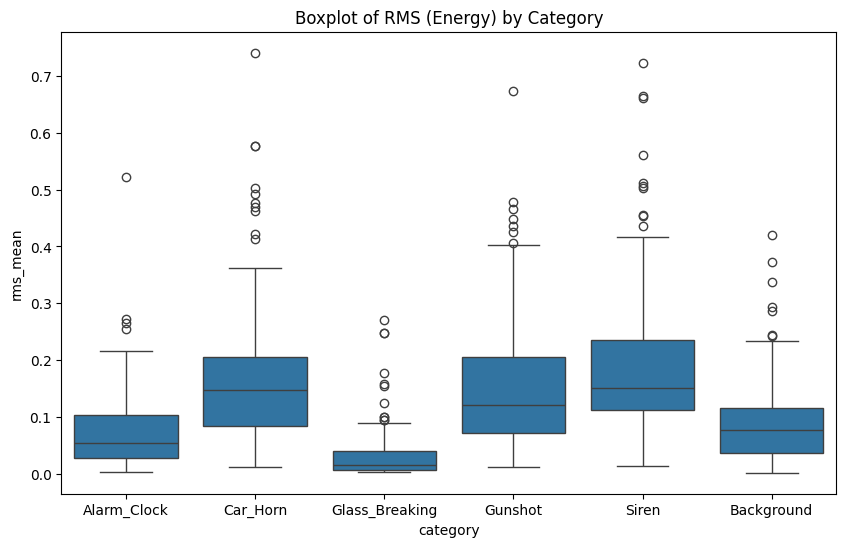

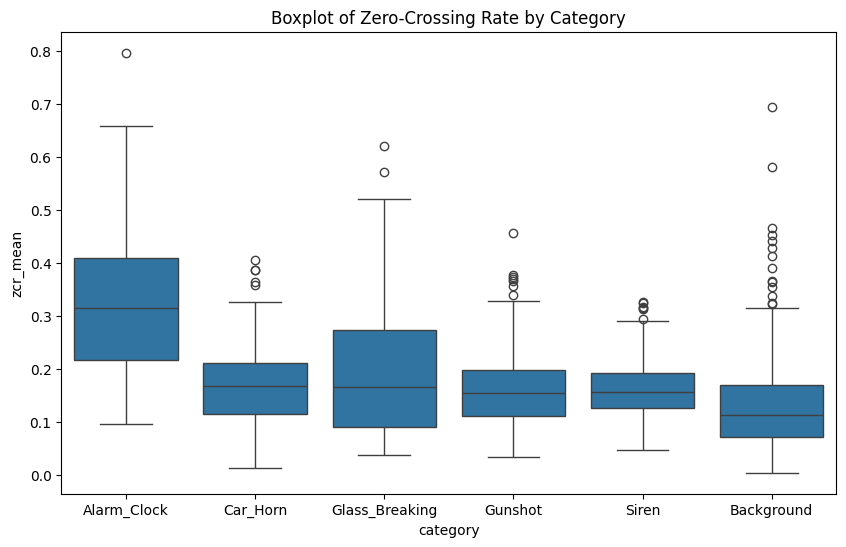

C:\Users\301364822\AppData\Local\Temp\ipykernel_24040\2952256332.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='snr_db', palette='Set2')


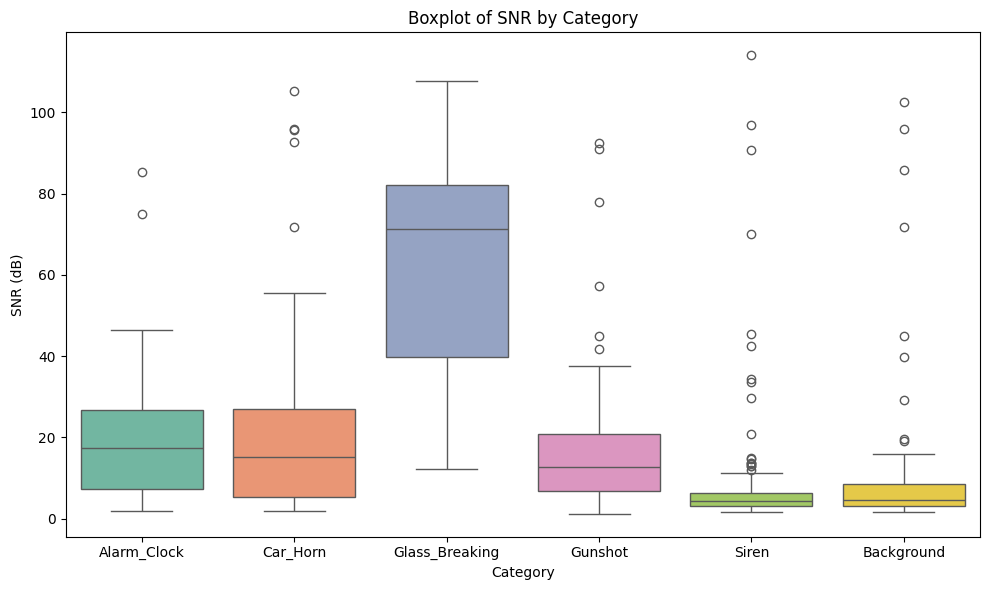

In [26]:
# Audio Quality Indicators: RMS, ZCR, Clipping, Silence, SNR
quality_stats = df.groupby('category')[['rms_mean', 'zcr_mean', 'snr_db']].agg(['mean', 'std'])
print("\nAudio Quality Stats per Category (RMS, ZCR, SNR):")
print(quality_stats)

clipped_files = df[df['is_clipped']]
silent_files = df[df['is_silent']]
zero_duration = df[df['duration_sec'] == 0]

print(f"Clipped Files: {len(clipped_files)}")
if not clipped_files.empty:
    print(clipped_files[['file', 'category', 'max_amp']])

print(f"Silent/Low-Amplitude Files: {len(silent_files)}")
if not silent_files.empty:
    print(silent_files[['file', 'category', 'rms_mean']])

print(f"Zero Duration Files: {len(zero_duration)}")
if not zero_duration.empty:
    print(zero_duration[['file', 'category']])

# Visualize RMS and ZCR and SNR
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='rms_mean')
plt.title('Boxplot of RMS (Energy) by Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='zcr_mean')
plt.title('Boxplot of Zero-Crossing Rate by Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='snr_db', palette='Set2')
plt.title('Boxplot of SNR by Category')
plt.ylabel('SNR (dB)')
plt.xlabel('Category')
plt.tight_layout()
plt.show()


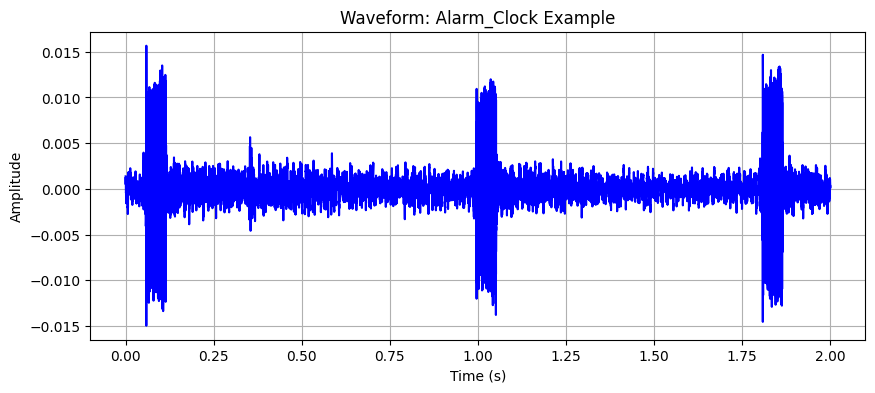

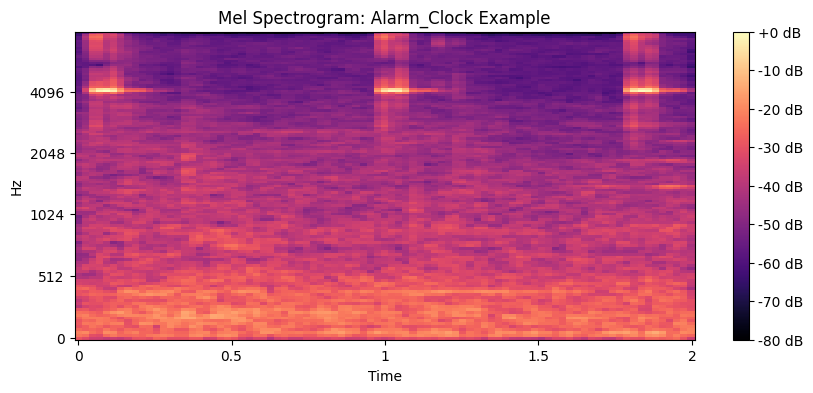

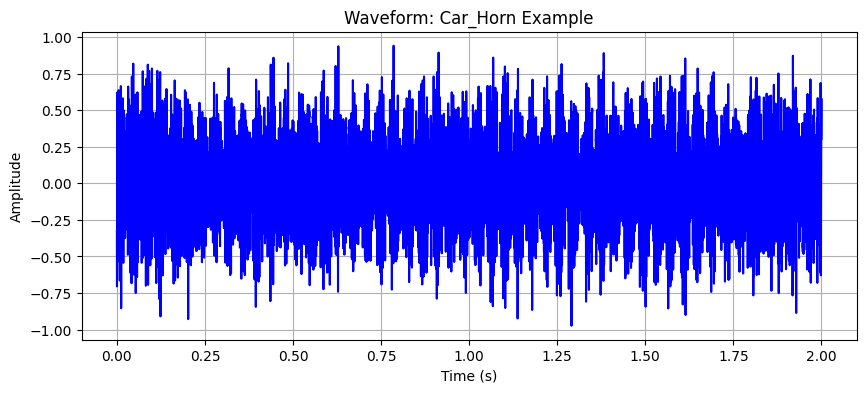

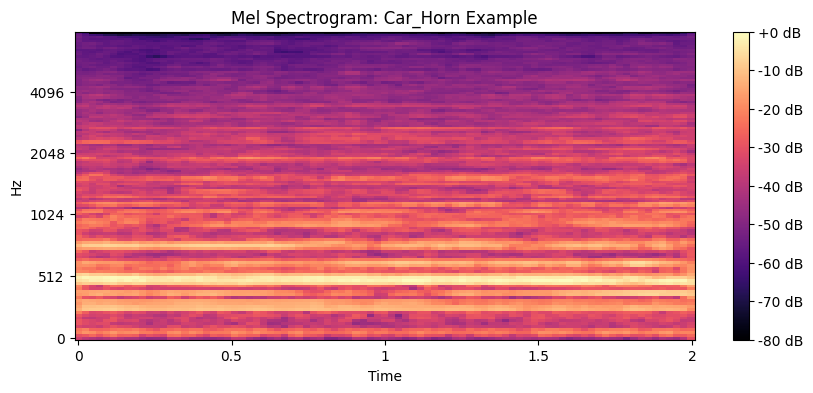

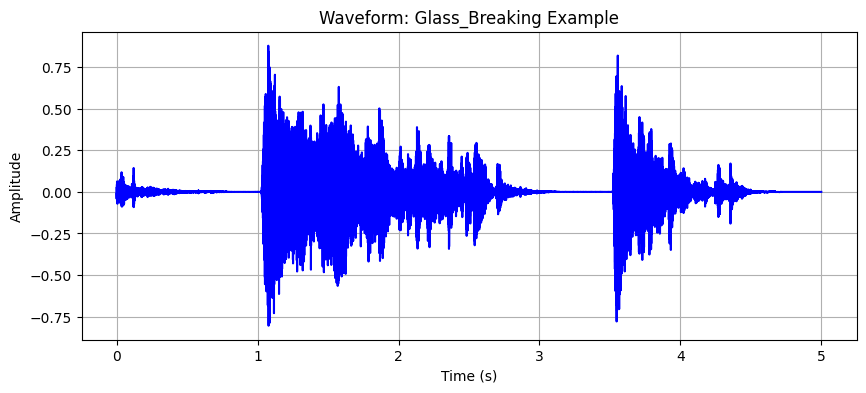

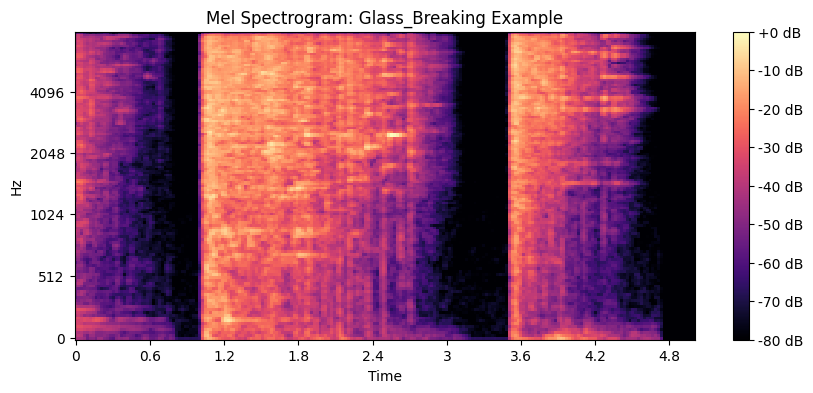

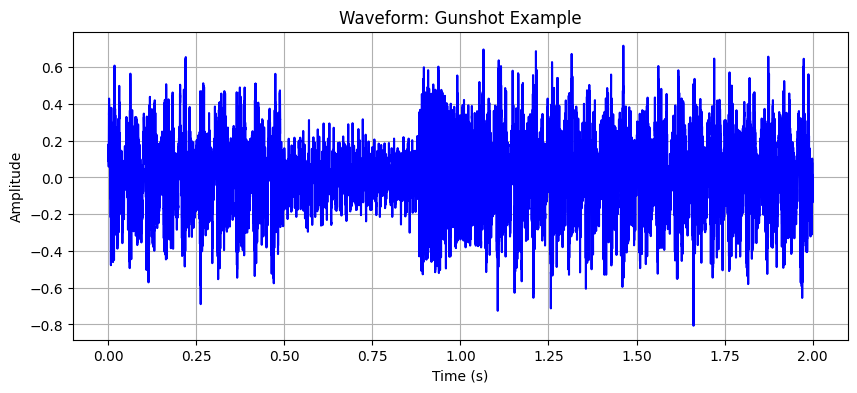

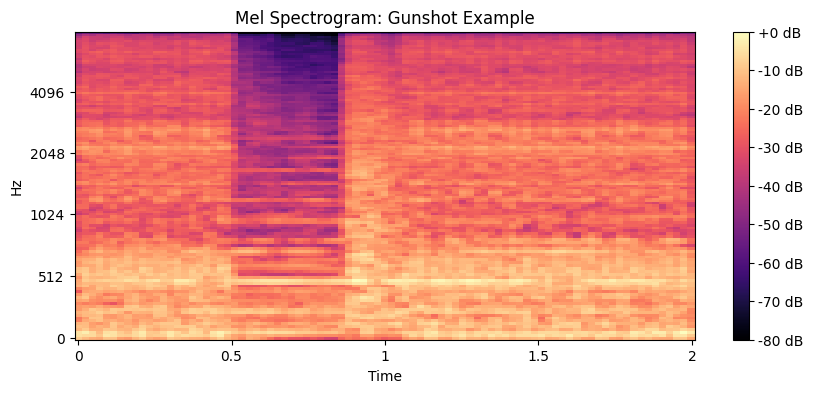

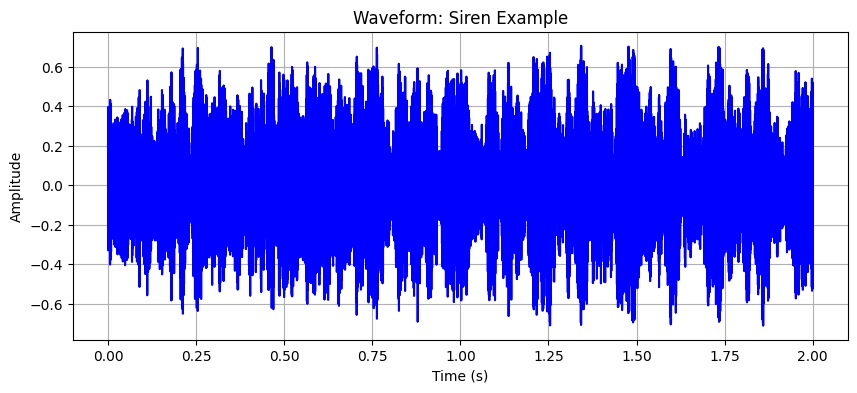

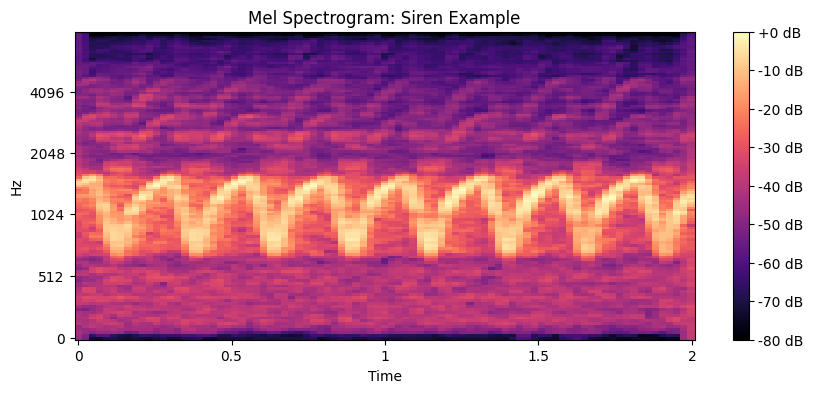

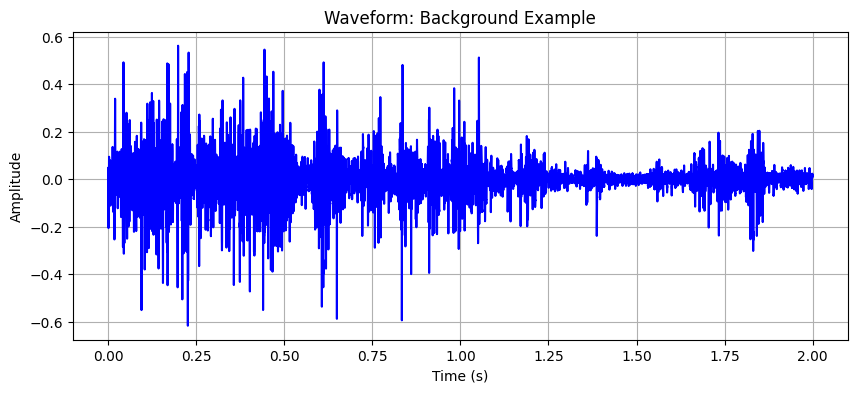

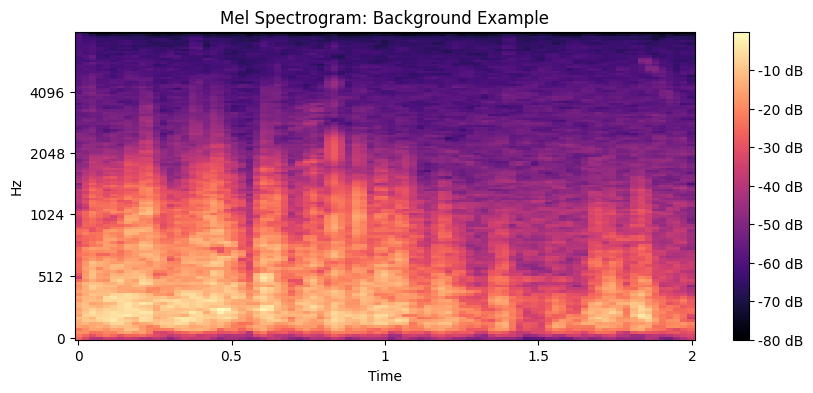

In [27]:
# Spectral Characteristics and Visuals: Waveforms, Spectrograms (one example per category)
for category in categories:
    sample_df = df[(df['category'] == category) & df['load_success']]
    if not sample_df.empty:
        sample_file = sample_df['file'].iloc[0]
        sample_path = os.path.join(data_dir, category, sample_file)
        y, sr = librosa.load(sample_path)
        
        # Waveform 
        plt.figure(figsize=(10, 4))
        time = np.linspace(0, len(y) / sr, num=len(y))
        plt.plot(time, y, color='b')
        plt.title(f'Waveform: {category} Example')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()
        
        # Mel Spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram: {category} Example')
        plt.show()

In [28]:
# Estimated Training Data: Total Frames, Frames per Class
frame_stats = df.groupby('category')['num_estimated_frames'].sum()
total_frames = frame_stats.sum()
print("\nEstimated YAMNet Frames (non-overlapping 0.96s):")
print(frame_stats)
print(f"Total Estimated Frames: {total_frames}")
if any(frame_stats < 100):
    print("Warning: Some classes have <100 frames; heavy augmentation needed.")



Estimated YAMNet Frames (non-overlapping 0.96s):
category
Alarm_Clock       372
Background        600
Car_Horn          593
Glass_Breaking    639
Gunshot           594
Siren             600
Name: num_estimated_frames, dtype: int64
Total Estimated Frames: 3398
